In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, roc_curve, auc
)

# ==========================
# 1️⃣ Load the datasets
# ==========================
features = pd.read_csv("dataset.csv")            # Contains: EAR, MAR, PERCLOS, HeadPitch
anfis_data = pd.read_csv("anfis_predictions.csv") # Contains: True_Label, Drowsy_Label

# Trim features to same number of samples as ANFIS predictions
N = len(anfis_data)
features = features.iloc[:N]

# Extract feature columns & labels
X = features[["EAR", "MAR", "PERCLOS", "HeadPitch"]]
y_true = anfis_data["True_Label"]
anfis_pred = anfis_data["Drowsy_Label"]

# ==========================
# 2️⃣ Train SVM
# ==========================
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X, y_true)
svm_pred = svm.predict(X)
svm_prob = svm.predict_proba(X)[:, 1]

# ==========================
# 3️⃣ Train KNN
# ==========================
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y_true)
knn_pred = knn.predict(X)
knn_prob = knn.predict_proba(X)[:, 1]

# ==========================
# 4️⃣ Evaluate function
# ==========================
def evaluate_model(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    print(f"\n=== {name} Performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

# Evaluate all three models
evaluate_model(y_true, anfis_pred, "ANFIS")
evaluate_model(y_true, svm_pred, "SVM")
evaluate_model(y_true, knn_pred, "KNN")




=== ANFIS Performance ===
Accuracy : 0.8885
Precision: 0.8803
Recall   : 0.8443
F1 Score : 0.8619

=== SVM Performance ===
Accuracy : 0.6081
Precision: 0.6364
Recall   : 0.1148
F1 Score : 0.1944

=== KNN Performance ===
Accuracy : 0.7635
Precision: 0.7826
Recall   : 0.5902
F1 Score : 0.6729


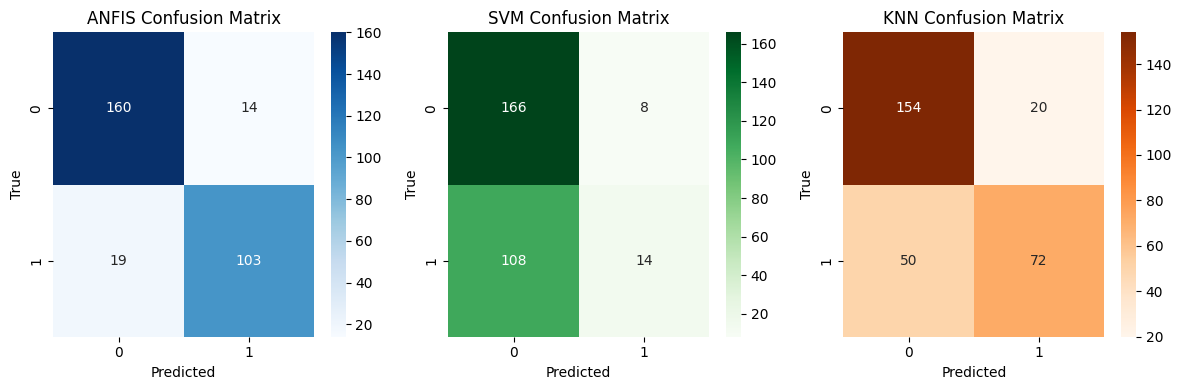

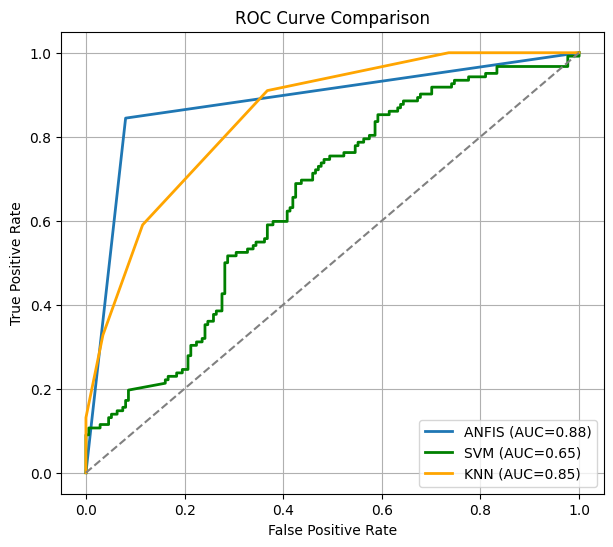

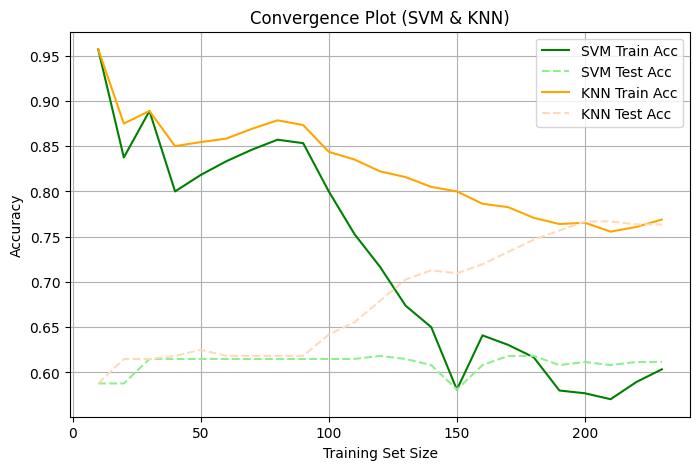


✅ Results saved as 'model_comparison_results.csv'


In [31]:
# ==========================
# 5️⃣ Confusion Matrices
# ==========================
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_true, anfis_pred), annot=True, fmt='d', cmap='Blues')
plt.title("ANFIS Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")

plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_true, svm_pred), annot=True, fmt='d', cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")

plt.subplot(1,3,3)
sns.heatmap(confusion_matrix(y_true, knn_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")

plt.tight_layout()
plt.show()

# ==========================
# 6️⃣ ROC Curve Comparison
# ==========================
fpr_anfis, tpr_anfis, _ = roc_curve(y_true, anfis_pred)
roc_auc_anfis = auc(fpr_anfis, tpr_anfis)

fpr_svm, tpr_svm, _ = roc_curve(y_true, svm_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(y_true, knn_prob)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(7,6))
plt.plot(fpr_anfis, tpr_anfis, label=f"ANFIS (AUC={roc_auc_anfis:.2f})", lw=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={roc_auc_svm:.2f})", lw=2, color='green')
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={roc_auc_knn:.2f})", lw=2, color='orange')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ==========================
# 7️⃣ Convergence Plots (Incremental training)
# ==========================
svm_train_acc, svm_test_acc = [], []
knn_train_acc, knn_test_acc = [], []

for size in range(10, len(X)+1, 10):
    y_slice = y_true[:size]
    if len(set(y_slice)) < 2:
        continue  # Skip slices with only 1 class

    X_slice = X[:size]
    svm.fit(X_slice, y_slice)
    knn.fit(X_slice, y_slice)

    svm_train_acc.append(accuracy_score(y_slice, svm.predict(X_slice)))
    knn_train_acc.append(accuracy_score(y_slice, knn.predict(X_slice)))

    svm_test_acc.append(accuracy_score(y_true, svm.predict(X)))
    knn_test_acc.append(accuracy_score(y_true, knn.predict(X)))

plt.figure(figsize=(8,5))
plt.plot(range(10, len(svm_train_acc)*10+1, 10), svm_train_acc, label="SVM Train Acc", color='green')
plt.plot(range(10, len(svm_test_acc)*10+1, 10), svm_test_acc, label="SVM Test Acc", color='lightgreen', linestyle='--')
plt.plot(range(10, len(knn_train_acc)*10+1, 10), knn_train_acc, label="KNN Train Acc", color='orange')
plt.plot(range(10, len(knn_test_acc)*10+1, 10), knn_test_acc, label="KNN Test Acc", color='peachpuff', linestyle='--')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Convergence Plot (SVM & KNN)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================
# 8️⃣ Save results
# ==========================
results = pd.DataFrame({
    "True_Label": y_true,
    "ANFIS_Prediction": anfis_pred,
    "SVM_Prediction": svm_pred,
    "KNN_Prediction": knn_pred
})
results.to_csv("model_comparison_results.csv", index=False)
print("\n✅ Results saved as 'model_comparison_results.csv'")
